In [4]:
import cartopy 
import glob
import matplotlib.pyplot as plt
import os
import xarray as xr
import xgcm 
from fastjmd95 import jmd95numba 
import numpy as np


BASE = '/scratch/ab10313/pleiades/'

PATH_LIST_PP = glob.glob(BASE+'*_smooth/preprcossed_data/')


In [2]:
PATH_LIST_PP

['/scratch/ab10313/pleiades/15_bengal_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/12_agulhas_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/11_new_zealand_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/08_kuroshio_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/10_north_pacific_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/04_equator_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/01_gulf_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/03_south_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/05_argentina_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/13_australia_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/06_california_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/14_indian_ocean_smooth/preprcossed_data/']

In [81]:
input_features_for_plot = [r'$\overline{\nabla b}^z$', '$f$','$H_{ML}$',r'$\tau$', '$Q^*$','$H_{BL}$',
                 '$\overline{\delta}^z$', '$\overline{\zeta}^z$', '$\overline{\sigma}^z$' ]


In [83]:
input_features = ['grad_B','FCOR', 'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain']
path= '/scratch/ab10313/pleiades/NN_data_1_4/'

# load features for input
in_features=[]
for input_feature in input_features:
    in_features.append(np.load(path+'%s.npy' % input_feature))
# x input
x_input_NF = np.stack(in_features,axis=1)

# load mean and std from features for input
std_in_features=[]
mean_in_features=[]
for input_feature in input_features:
    mean_in_features.append(np.load(path+'%s_mean.npy' % input_feature)*np.ones((x_input_NF.shape[0],x_input_NF.shape[2],x_input_NF.shape[3])))
    std_in_features.append(np.load(path+'%s_std.npy' % input_feature)*np.ones((x_input_NF.shape[0],x_input_NF.shape[2],x_input_NF.shape[3])))

x_mean = np.stack(mean_in_features,axis=1)
x_std = np.stack(std_in_features,axis=1)


x_norm_NF = (x_input_NF - x_mean)/x_std

In [84]:
input_features = ['grad_B','FCOR', 'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain']
path= '/scratch/ab10313/pleiades/temporal_filter_NN_data/NN_data_1_8/'

# load features for input
in_features=[]
for input_feature in input_features:
    in_features.append(np.load(path+'%s.npy' % input_feature))
# x input
x_input_TF = np.stack(in_features,axis=1)

# load mean and std from features for input
std_in_features=[]
mean_in_features=[]
for input_feature in input_features:
    mean_in_features.append(np.load(path+'%s_mean.npy' % input_feature)*np.ones((x_input_TF.shape[0],x_input_TF.shape[2],x_input_TF.shape[3])))
    std_in_features.append(np.load(path+'%s_std.npy' % input_feature)*np.ones((x_input_TF.shape[0],x_input_TF.shape[2],x_input_TF.shape[3])))

x_mean = np.stack(mean_in_features,axis=1)
x_std = np.stack(std_in_features,axis=1)


x_norm_TF = (x_input_TF - x_mean)/x_std

In [1]:
import torch
import torch.utils.data as Data
from torch.utils.data import DataLoader

import submeso_ml.data.dataset as dataset

# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
    

# example of halo for 1/4 case
submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'HML', 'TAU',
          'Q', 'HBL', 'div', 'vort', 'strain'], res='1_8')

test_loader=DataLoader(
submeso_dataset,
batch_size=256,
sampler=submeso_dataset.test_ind)

model = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_res_1_8_NF.pt')


for x_data, y_data in test_loader:
    x_input_NF= x_data
    y_NF= y_data
    x_input_NF.requires_grad = True
    pred_NF = model(x_input_NF.to(device))

CUDA Not Available


In [2]:
pred_NF.shape

torch.Size([14, 1, 80, 80])

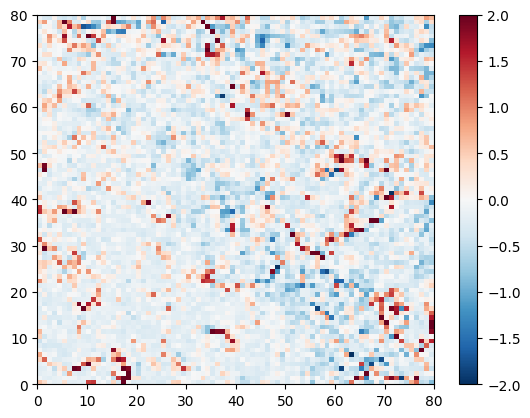

In [7]:
plt.pcolor(y_NF[10,0,:,:], cmap='RdBu_r', vmin=-2, vmax=2)
plt.colorbar()

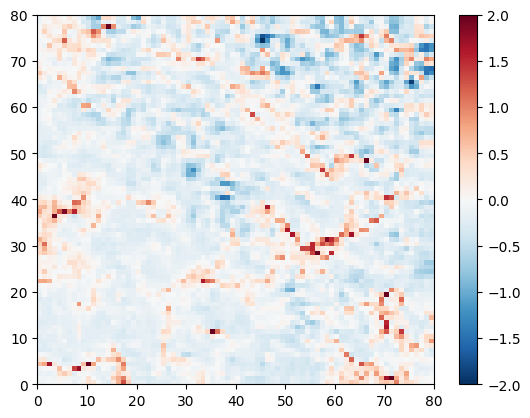

In [8]:
plt.pcolor(pred_NF[10,0,:,:].detach().numpy(), cmap='RdBu_r', vmin=-2, vmax=2)
plt.colorbar()

In [108]:
# load output
path= '/scratch/ab10313/pleiades/NN_data_1_12/'
WB_sg = np.load(path+'WB_sg.npy')
y_NF = np.tile(WB_sg,(1,1,1,1)).reshape(WB_sg.shape[0],1,WB_sg.shape[1],WB_sg.shape[2])

y_mean = np.load(path+'WB_sg_mean.npy')*np.ones(y_NF.shape)
y_std = np.load(path+'WB_sg_std.npy')*np.ones(y_NF.shape)
y_norm_NF = (y_NF - y_mean)/y_std

In [109]:
# load output
path= '/scratch/ab10313/pleiades/temporal_filter_NN_data/NN_data_1_12/'
WB_sg = np.load(path+'WB_sg.npy')
y_TF = np.tile(WB_sg,(1,1,1,1)).reshape(WB_sg.shape[0],1,WB_sg.shape[1],WB_sg.shape[2])

y_mean = np.load(path+'WB_sg_mean.npy')*np.ones(y_TF.shape)
y_std = np.load(path+'WB_sg_std.npy')*np.ones(y_TF.shape)
y_norm_TF = (y_TF - y_mean)/y_std

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

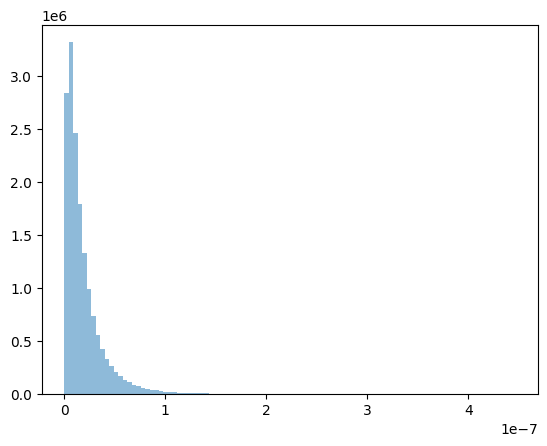

In [110]:
plt.hist(x_input_TF[:,0,:,:].flatten(),bins=100,alpha=.5);
plt.hist(x_input_NF[:,0,:,:].flatten(),bins=100,alpha=.5);

(-5e-07, 5e-07)

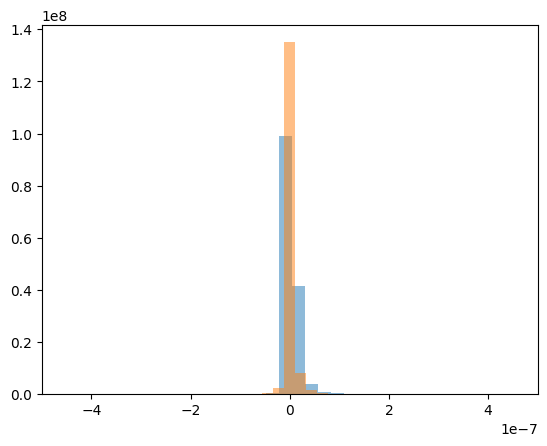

In [111]:
plt.hist(y_TF[:,:,:].flatten(),bins=100,alpha=.5);
plt.hist(y_NF[:,:,:].flatten(),bins=100,alpha=.5);
plt.xlim([-.5e-6, 0.5e-6])

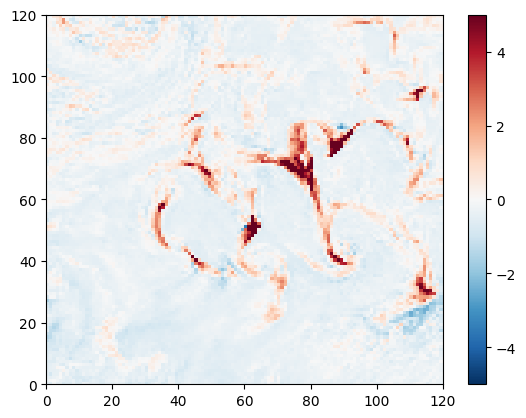

In [115]:
plt.pcolor(y_norm_TF[20,0,:,:], cmap='RdBu_r',vmin=-5, vmax = 5)
plt.colorbar()

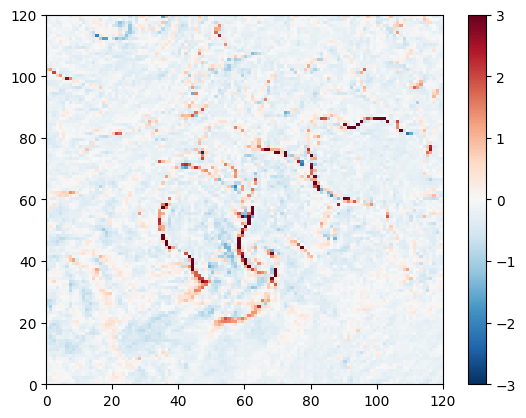

In [118]:
plt.pcolor(y_norm_NF[20,0,:,:], cmap='RdBu_r',vmin=-3, vmax = 3)
plt.colorbar()

## plot of normalized inputs

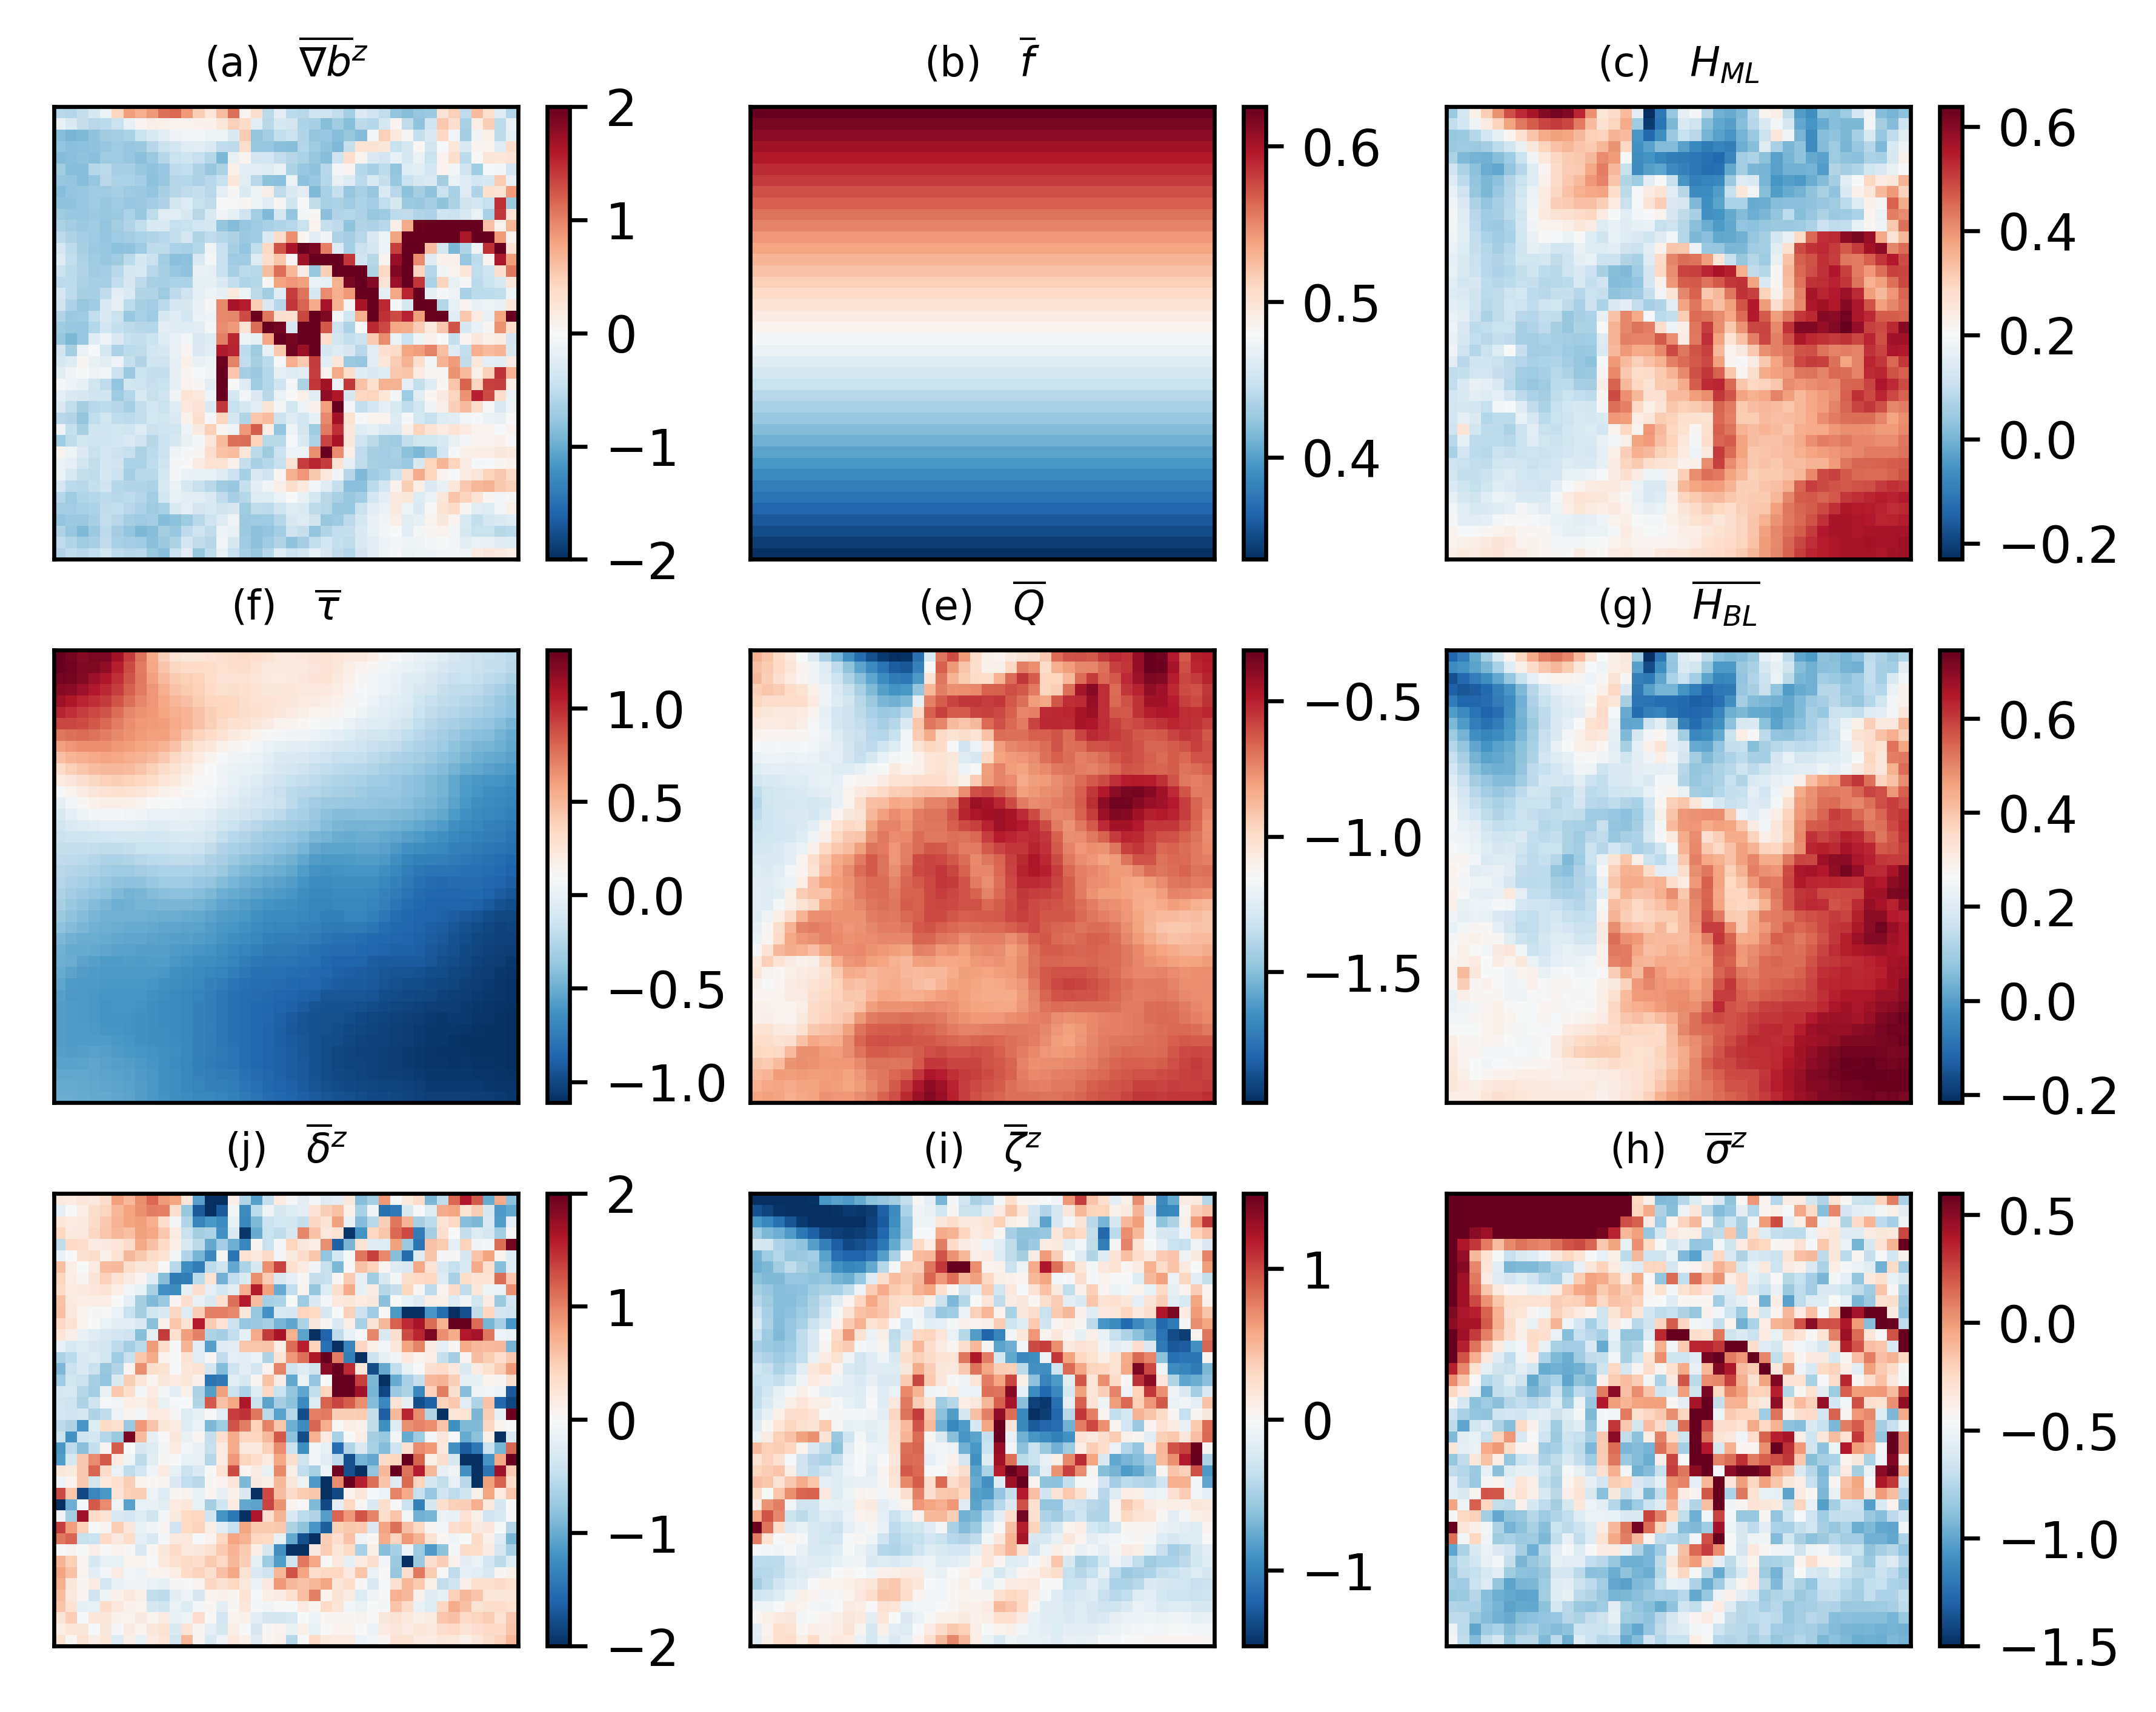

In [6]:
plt.subplots(nrows=2, ncols=5, figsize=(7, 5.5), dpi=600)
#plt.rcParams.update({'font.size': 8})
plt.subplot(122)
it =0
    

plt.subplot(331)
plt.pcolor(x_norm[it,0,:,:],vmin=-2,vmax=2, cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(a)   '+ r'$\overline{\nabla b}^z$',fontsize=8)

plt.subplot(332)
plt.pcolor(x_norm[it,1,:,:],  cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(b)   $\overline{f}$',fontsize=8)

plt.subplot(333)
plt.pcolor(x_norm[it,2,:,:],  cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(c)   '+r'$H_{ML}$',fontsize=8)


plt.subplot(334)
plt.pcolor(x_norm[it,3,:,:], cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(f)   '+r'$\overline{\tau}$',fontsize=8)

plt.subplot(335)
plt.pcolor(x_norm[it,4,:,:], cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(e)   '+r'$\overline{Q}$',fontsize=8)

plt.subplot(336)
plt.pcolor(-x_norm[it,5,:,:], cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(g)   '+'$\overline{H_{BL}}$',fontsize=8)

plt.subplot(337)
plt.pcolor(x_norm[it,6,:,:],vmin=-2,vmax=2,  cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(j)   '+'$\overline{\delta}^z$',fontsize=8)

plt.subplot(338)
plt.pcolor(x_norm[it,7,:,:], vmin=-1.5,vmax=1.5, cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(i)   '+'$\overline{\zeta}^z$',fontsize=8)

plt.subplot(3,3,9)
plt.pcolor(x_norm[it,8,:,:],vmin=-1.5,vmax=.6,  cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(h)   '+'$\overline{\sigma}^z$',fontsize=8)

#plt.subplot(3,4,12)
#plt.pcolor(Y_output_gulf[it,0,:,:], cmap='RdBu_r')
##plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.colorbar()
#plt.xticks([])
#plt.yticks([])
#plt.title('(k)   '+r'$\overline{w^\prime b^\prime}^z$',fontsize=34)

#[FCOR, grad_B, HML, Nsquared, TAU, Q, HBL, div, vort, strain]
plt.rcParams.update({'font.size': 8})
plt.savefig('./figures/inputs_normalized.png')

## plots of physical space inputs

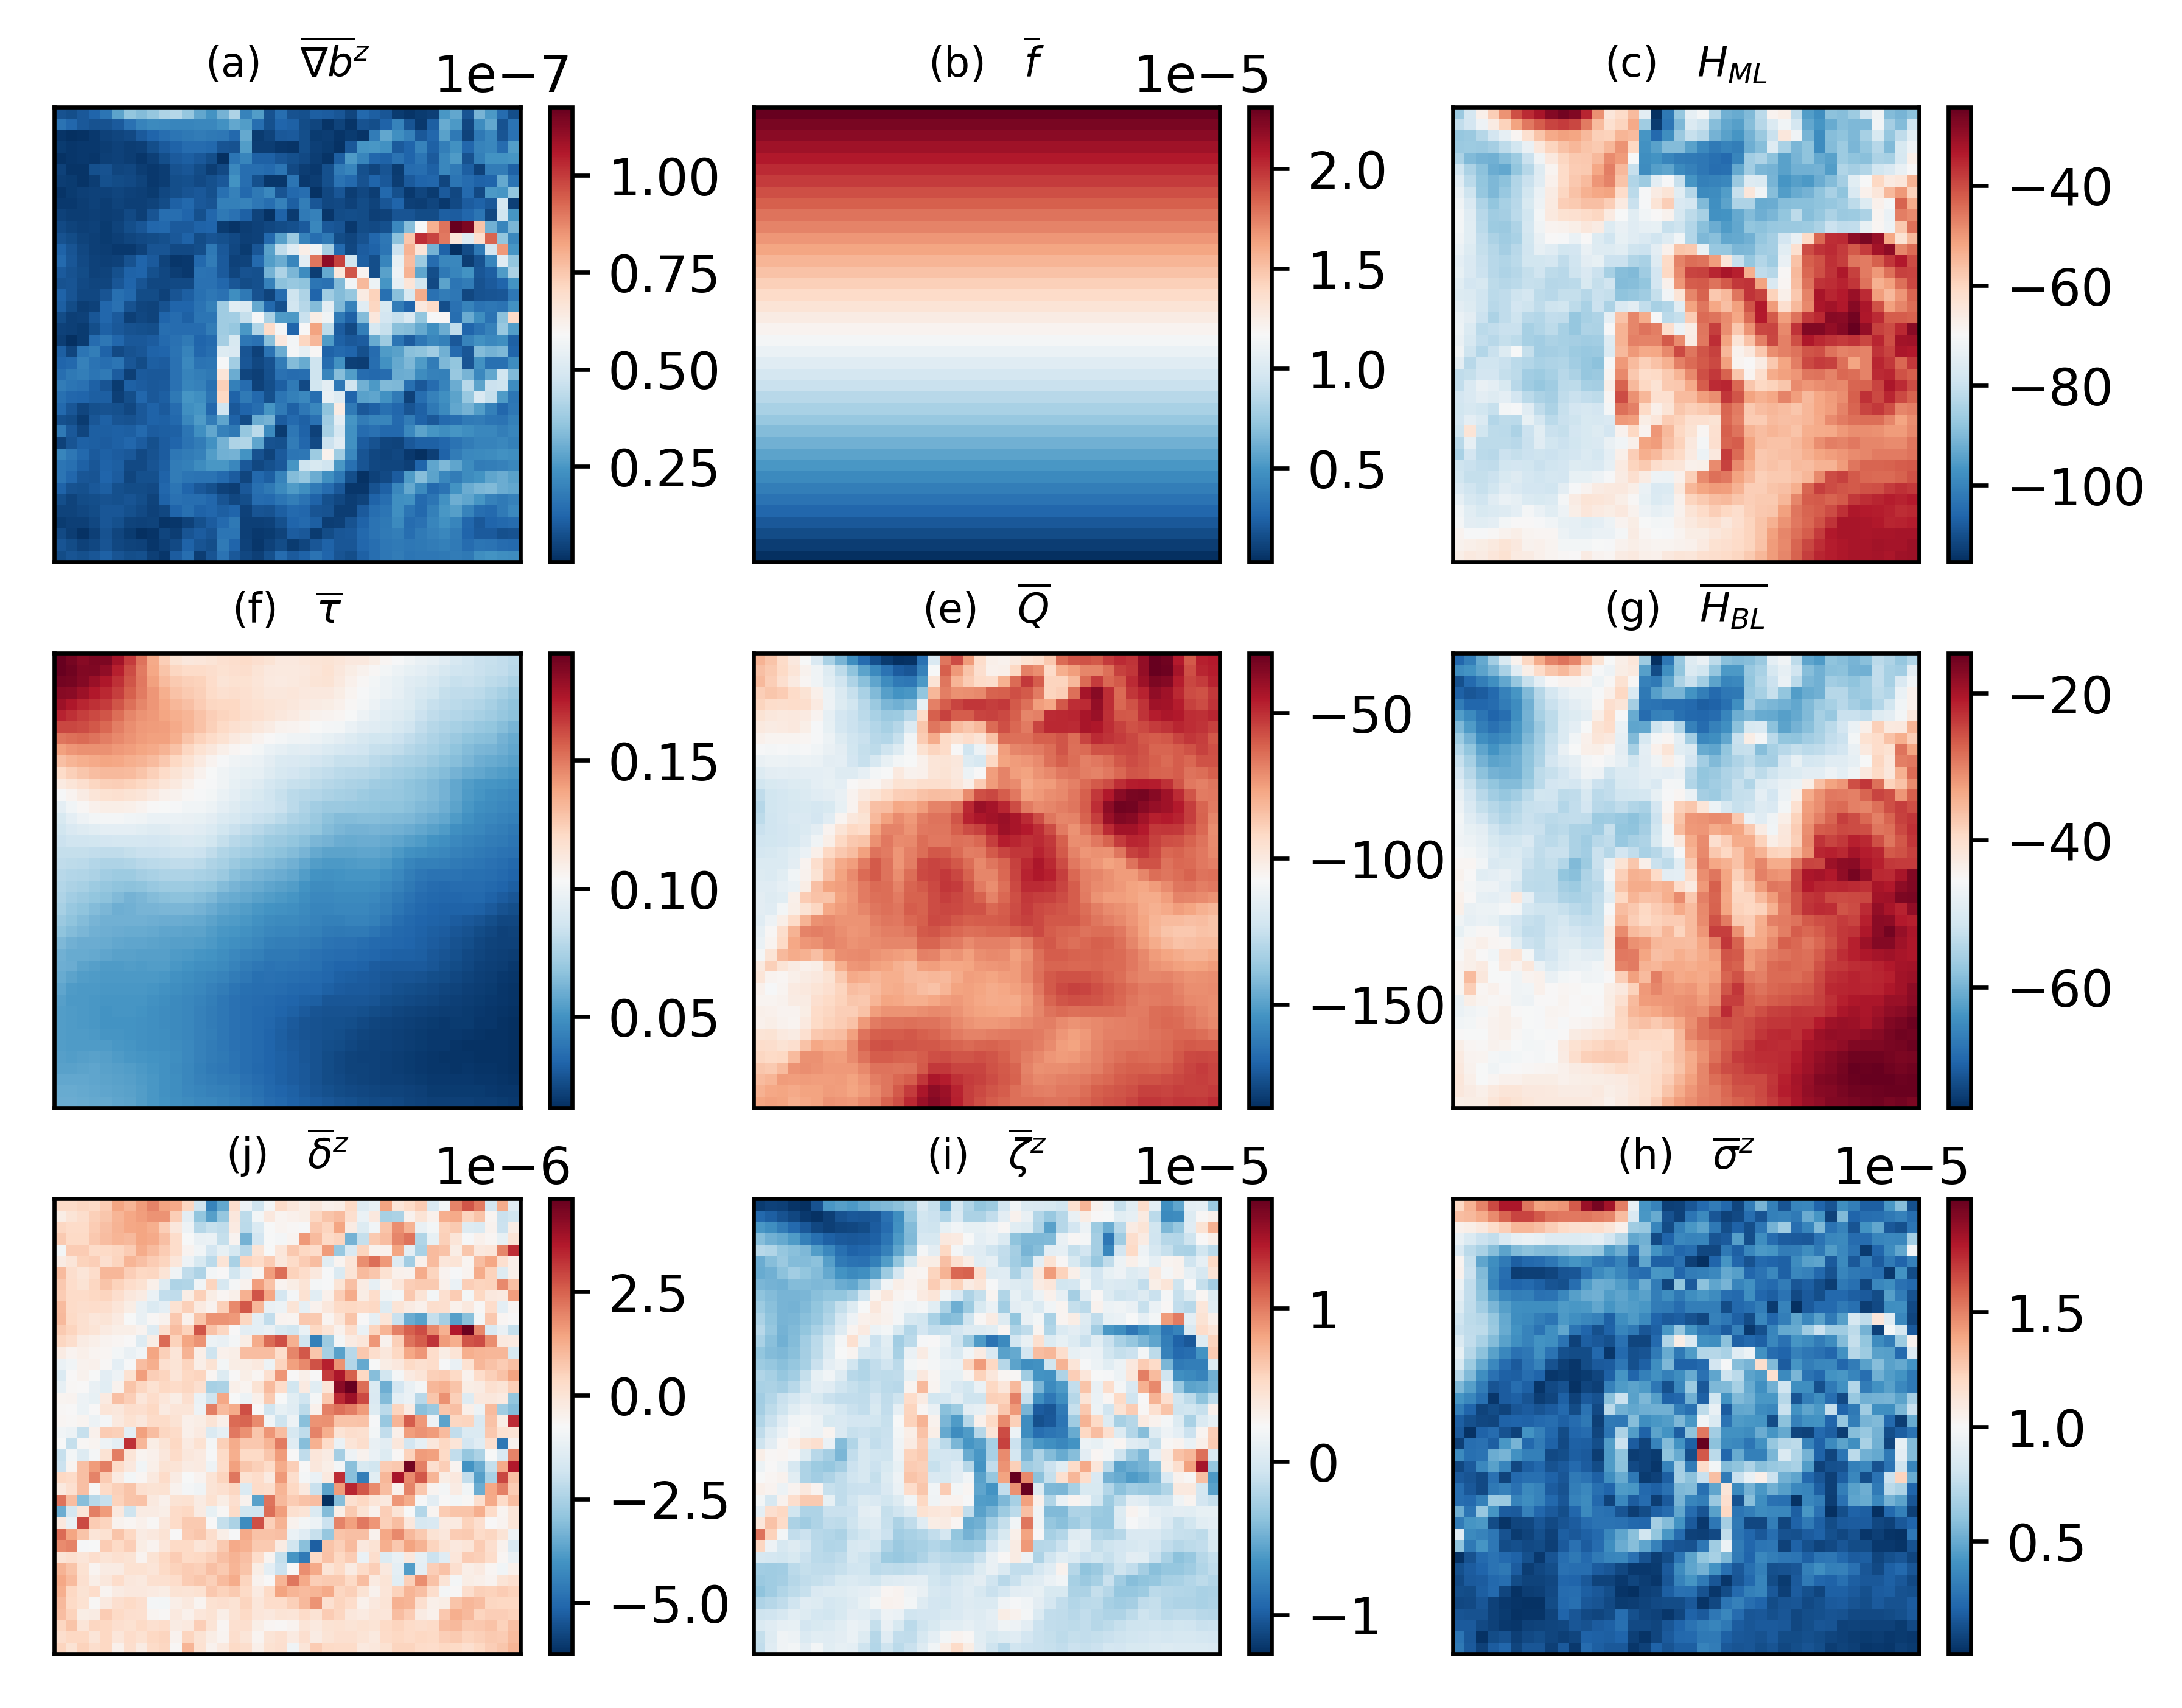

In [6]:
plt.subplots(nrows=2, ncols=5, figsize=(7, 5.5), dpi=600)
#plt.rcParams.update({'font.size': 8})
plt.subplot(122)
it =0
    

plt.subplot(331)
plt.pcolor(x_input[it,0,:,:], cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(a)   '+ r'$\overline{\nabla b}^z$',fontsize=8)

plt.subplot(332)
plt.pcolor(x_input[it,1,:,:],  cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(b)   $\overline{f}$',fontsize=8)

plt.subplot(333)
plt.pcolor(x_input[it,2,:,:],  cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(c)   '+r'$H_{ML}$',fontsize=8)


plt.subplot(334)
plt.pcolor(x_input[it,3,:,:], cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(f)   '+r'$\overline{\tau}$',fontsize=8)

plt.subplot(335)
plt.pcolor(x_input[it,4,:,:], cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(e)   '+r'$\overline{Q}$',fontsize=8)

plt.subplot(336)
plt.pcolor(-x_input[it,5,:,:], cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(g)   '+'$\overline{H_{BL}}$',fontsize=8)

plt.subplot(337)
plt.pcolor(x_input[it,6,:,:], cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(j)   '+'$\overline{\delta}^z$',fontsize=8)

plt.subplot(338)
plt.pcolor(x_input[it,7,:,:], cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(i)   '+'$\overline{\zeta}^z$',fontsize=8)

plt.subplot(3,3,9)
plt.pcolor(x_input[it,8,:,:], cmap='RdBu_r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('(h)   '+'$\overline{\sigma}^z$',fontsize=8)


#[FCOR, grad_B, HML, Nsquared, TAU, Q, HBL, div, vort, strain]
plt.rcParams.update({'font.size': 8})
plt.savefig('./figures/inputs_physical_space.png')

## correlation map between input features

In [215]:
input_features = ['grad_B','FCOR', 'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain']
path= '/scratch/ab10313/pleiades_new/NN_data_1_2/'

# load features for input
in_features=[]
for input_feature in input_features:
    in_features.append(np.load(path+'%s.npy' % input_feature))
# x input
x_input = np.stack(in_features,axis=1)

# load mean and std from features for input
std_in_features=[]
mean_in_features=[]
for input_feature in input_features:
    mean_in_features.append(np.load(path+'%s_mean.npy' % input_feature)*np.ones((x_input.shape[0],x_input.shape[2],x_input.shape[3])))
    std_in_features.append(np.load(path+'%s_std.npy' % input_feature)*np.ones((x_input.shape[0],x_input.shape[2],x_input.shape[3])))

x_mean = np.stack(mean_in_features,axis=1)
x_std = np.stack(std_in_features,axis=1)


x_norm = (x_input - x_mean)/x_std

In [309]:
def Pearson_correlation(X,Y):
    if len(X)==len(Y):
        Sum_xy = sum((X-X.mean())*(Y-Y.mean()))
        Sum_x_squared = sum((X-X.mean())**2)
        Sum_y_squared = sum((Y-Y.mean())**2)       
        corr = Sum_xy / np.sqrt(Sum_x_squared * Sum_y_squared)
    return corr


NameError: name 'x' is not defined

-0.38071571667780113


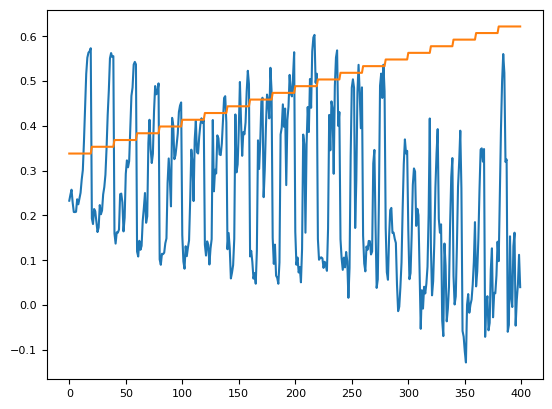

In [355]:
i=2
plt.plot(x_norm[0,i,:,:].flatten())
plt.plot(x_norm[0,j,:,:].flatten())
corr_mat[i,j],_ = pearsonr(x_norm[0,i,:,:].ravel(),x_norm[0,j,:,:].ravel())
print(corr_mat[i,j])

0.8092716788441001


0.8092716788440986

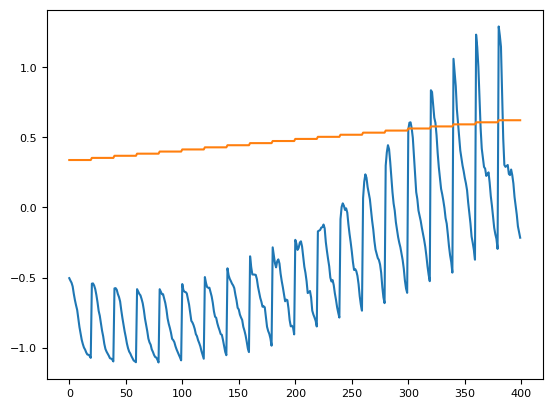

In [313]:
i=3
plt.plot(x_norm[0,i,:,:].flatten())
plt.plot(x_norm[0,j,:,:].flatten())
corr_mat[i,j],_ = pearsonr(x_norm[0,i,:,:].flatten(),x_norm[0,j,:,:].flatten())
print(corr_mat[i,j])
Pearson_correlation(x_norm[0,i,:,:].flatten(),x_norm[0,j,:,:].flatten())

-0.25813139022004616


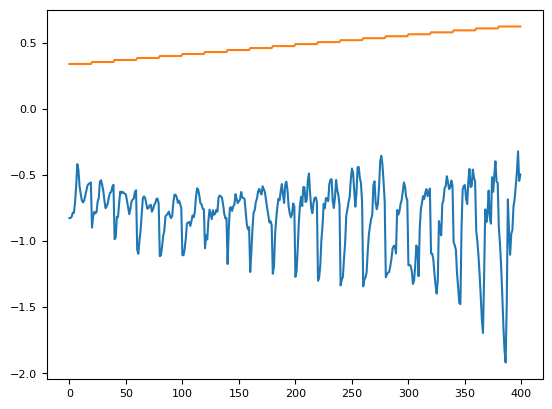

In [301]:
i=4
plt.plot(x_norm[0,i,:,:].flatten())
plt.plot(x_norm[0,j,:,:].flatten())
corr_mat[i,j],_ = pearsonr(x_norm[0,i,:,:].flatten(),x_norm[0,j,:,:].flatten())
print(corr_mat[i,j])

0.6275739168519957


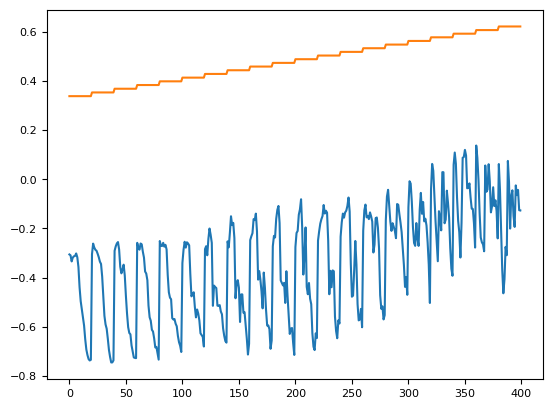

In [314]:
i=5
plt.plot(x_norm[0,i,:,:].flatten())
plt.plot(x_norm[0,j,:,:].flatten())
corr_mat[i,j],_ = pearsonr(x_norm[0,i,:,:].flatten(),x_norm[0,j,:,:].flatten())
print(corr_mat[i,j])

-0.06305597778564696


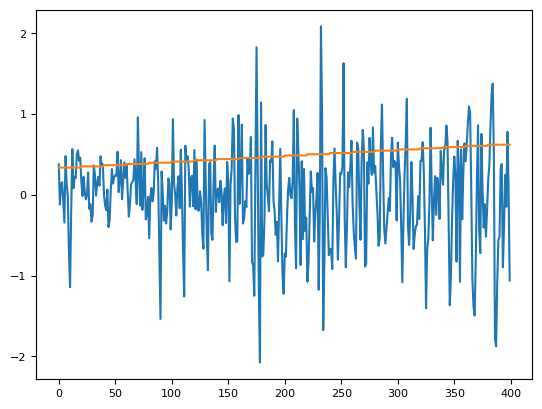

In [315]:
i=6
plt.plot(x_norm[0,i,:,:].flatten())
plt.plot(x_norm[0,j,:,:].flatten())
corr_mat[i,j],_ = pearsonr(x_norm[0,i,:,:].flatten(),x_norm[0,j,:,:].flatten())
print(corr_mat[i,j])

-0.16877345472966696


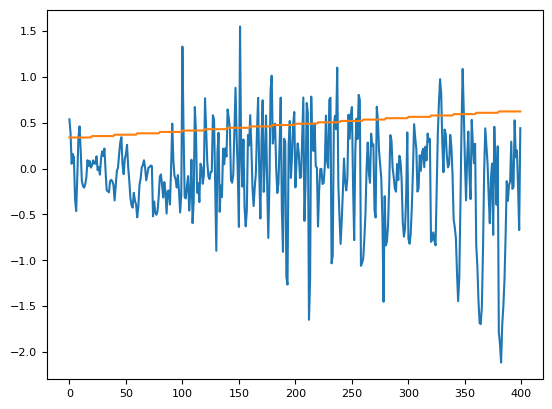

In [316]:
i=7
plt.plot(x_norm[0,i,:,:].flatten())
plt.plot(x_norm[0,j,:,:].flatten())
corr_mat[i,j],_ = pearsonr(x_norm[0,i,:,:].flatten(),x_norm[0,j,:,:].flatten())
print(corr_mat[i,j])

0.5059813955264555


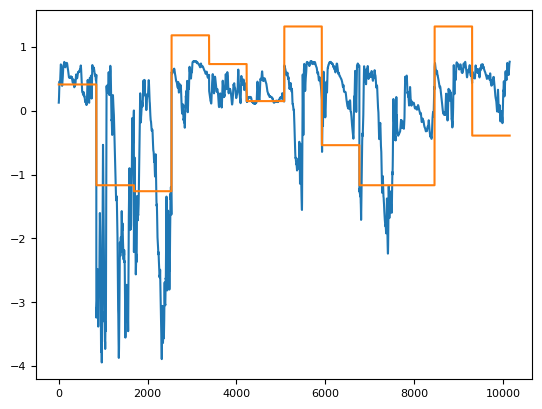

In [352]:
i=2
plt.plot(x_norm[:,i,5,5].flatten())
plt.plot(x_norm[:,j,5,5].flatten())
corr_mat[i,j],_ = pearsonr(x_norm[:,i,5,5].flatten(),x_norm[:,j,5,5].flatten())
print(corr_mat[i,j])

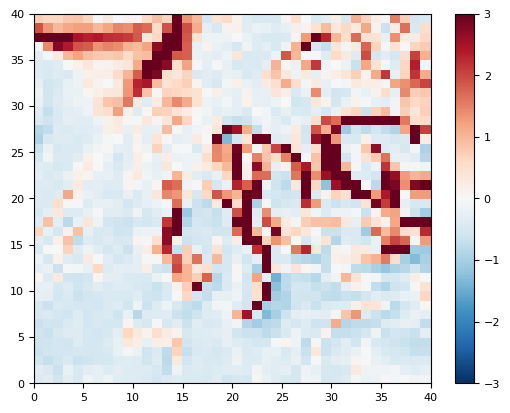

In [382]:
plt.pcolor(y_norm[0,0,:,:], cmap='RdBu_r',vmin=-3, vmax=3)
plt.colorbar()

In [397]:
y_norm.shape

(10152, 1, 40, 40)

In [401]:
xy_norm = np.concatenate([x_norm,y_norm],axis=1)


In [399]:
xy.shape

(10152, 10, 40, 40)

In [404]:
from scipy.stats import pearsonr

corr_mat = np.zeros((10,10))
xy_norm[:,5,:,:] = -xy_norm[:,5,:,:]

for i in range(10):
    for j in range(10):
        corr_mat[i,j] = Pearson_correlation(xy_norm[:850,i,:,:].ravel(),xy_norm[:850,j,:,:].ravel())
        #print('i=',i,', j=',j)        


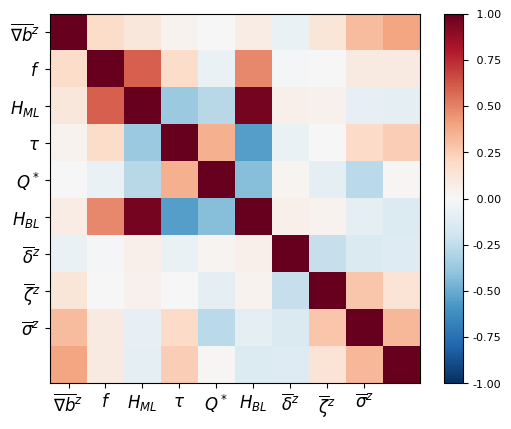

In [405]:
fig, ax = plt.subplots()
im = ax.imshow(corr_mat,cmap='RdBu_r', vmin=-1, vmax=1)
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.xticks(range(9),input_features_for_plot,fontsize=12)
plt.yticks(range(9),input_features_for_plot,fontsize=12);